In [13]:
#imports principais de Python
import numpy as np
import os
from matplotlib import pyplot as plt
%matplotlib inline
#frameworks
import tensorflow as tf
import keras 
from keras import backend as K
#leitura e processamento de imagens
import cv2
import pandas as pd
import scipy.io
import scipy.misc
import PIL
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
#CNNs no Keras
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
from keras import models, layers
from keras.models import load_model, Model, Sequential
from keras.layers import Reshape, Merge,Activation, Conv2D, Flatten,Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.merge import concatenate
from keras.layers.core import Activation, Reshape
#funções em script 
import sys
sys.path.append('../')
from source.yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from source.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

# Introdução

YOLO, ou You Only Look Once (Você olha apenas uma vez), é um algoritmo de detecção capaz de, em tempo real, realizar o reconhecimento de um objeto e localizá-lo na imagem simultaneamente. Para isso, o algoritmo vai além da arquitetura da YOLO apresentada no primeiro notebook. 

Assim, a primeira etapa do algoritmo é dividir a imagem em um sistema de grids de dimensões 13x13, obtendo-se assim 169 blocos ou células da imagem original, conforme imagem abaixo.

![alt text](../imgs/grids.png "Title")

# O Algoritmo
Uma vez obtidos os blocos de imagem, a YOLO calculará, para cada um desses blocos, 
uma quantidade N de bounding boxes (normalmente 5) e seus respectivos scores. Esse score contém a o grau de confiança do algoritmo em conter ou não um objeto no bloco, caso não exista, o algoritmo retorna um score igual a zero. Além do score, o algoritmo retorna para cada bounding box:
1. As coordenadas (x,y) do centro da bounding box
2. As dimensões (width, height) da bounding box relativa a imagem
3. A probabilidade C da bounding box conter um objeto de cada classe, onde C é uma lista com as probabilidades para cada uma dessas classes 

Após calculados todos os parâmetros de cada bouding box, a YOLO retorna a bounding box que obtiver maior score e realiza a predição final p de acordo com a equação p = SxSx(N*5 + C), onde S é o número de grids (13x13 por exemplo), N a quantidade de bounding boxes e C a probabilidade da classe com o maior valor para a bounding box selecionada. Com isso, o modelo CNN da YOLO(tanto na versão v1 quanto na v2 ou 9000) aprende os valores a utilizados como parâmetros da bounding box até o fim do treinamento.

Baseado nisso, a figura abaixo exemplifica o algoritmo da YOLO para um sistema de grids 5x5, disponível do [artigo da YOLO](https://arxiv.org/pdf/1506.02640.pdf).

![alt text](../imgs/algoritmo yolo.png "Title")


# Calculando o Score

No algoritmo da YOLO, o primeiro conceito a ser estudado é o cálculo do Score, obtido a partir da Intersection Over Union (IoU).

IoU é uma métrica de avaliação utilizada na maioria das abordagens de detecção de objetos e é calculada a partir das dimensões da bounding box calculada e da bounding box que representa de fato o objeto (disponível nos labels da base de dados de treinamento).

Obtendo-se essas dimensões, calcula-se a área das bounding boxes, a interseção e a união entre elas. Feito isso, a IoU é dada simplesmente pela razão entre a interseção e a união, conforme equação abaixo.

$$ IoU = \frac{B_1\cap B_2}{B_1\cup B_2}$$

Assim, dadas as coordenadas (x,y) de cada bouding box, calcula-se a área de intereseção a partir do cálculo de distância máxima e mínima dos vértices das duas bounding box e a área de união entre elas. A figura abaixo ilustra o cálculo da IoU. Quanto maior o seu valor, maior o nível de confiança do algoritmo em existir um dado objeto no bloco de imagem analisado.

![alt text](../imgs/iou.png "Title")


In [2]:
def iou(box1, box2):
    """Implementação da IoU para duas bounding boxes 
    
    Parâmetros:
    box1 -- coordenadas da box verdadeira disponível nos labels (x1, y1, x2, y2)
    box2 -- coordenadas da bouding box calculada (x1, y1, x2, y2)
    """
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    inter_area = (xi2 - xi1)*(yi2 - yi1)

    box1_area = (box1[3] - box1[1])*(box1[2]- box1[0])
    box2_area = (box2[3] - box2[1])*(box2[2]- box2[0])
    union_area = (box1_area + box2_area) - inter_area

    iou = inter_area / union_area

    return iou


Para exemplificar a implementação da IoU, no código abaixo temos uma imagem e duas bounding boxes. A verdadeira (em verde) e a calculada (azul) e suas respectivas coordenadas, percebemos pela imagem que a bounding box calculada possui dimensões um pouco diferentes.

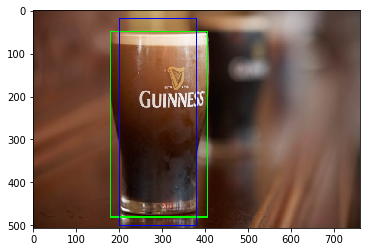

In [3]:
image = cv2.imread("../imgs/guiness.jpg")

cv2.rectangle(image,(405, 50), 
		(180,480), (0, 255, 0), 2)

cv2.rectangle(image,(380, 20), 
		(200,500), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Em um segundo exemplo, a bounding box calculada tem valores bem semelhantes ao desejado, de forma que, ao comparar as duas bounding box calculadas, essa seria a melhor entre elas.

Uma vez calculada a IoU, o score pode ser calculado multiplicando-a pela probabilidade das classes C.

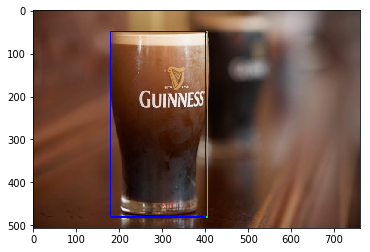

In [4]:
image = cv2.imread("../imgs/guiness.jpg")

cv2.rectangle(image,(405, 50), 
		(180,480), (0, 255, 0), 2)

cv2.rectangle(image,(400, 50), 
		(180,480), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

Para comrovar isso, o código abaixo contém as coordendas dos dois exemplos respectivamente. Percebe-se que, para o segundo caso, o valor da IoU é bem próximo de 1, comprovando-se assim que essa é a melhor bounding box.

In [5]:
box1 = (405, 50, 180, 480)
box2 = (380, 20, 200, 500) 
print("iou = " + str(iou(box1, box2)))

box1 = (405, 50, 180, 480)
box2 = (400, 50, 180, 480) 
print("iou = " + str(iou(box1, box2)))

iou = 1.1197916666666667
iou = 1.0227272727272727


# Filtrando Resultados - Aplicação de Limiar

Além do cálculo da IoU, mesmo que o algoritmo selecione as bounding boxes com maiores resultados de cada bloco, ainda assim existem muitas boxes para um mesmo objeto, tornando-se assim necessário filtra-las para obter o resultado final, o que pode ser observado na figura abaixo. 

![alt text](../imgs/algoritmo yolo.png "Title")

Dessa forma, o primeiro passo do algoritmo é filtrar as bounding boxes baseado em um limiar, afim de eliminar aquelas que não possuem uma alta taxa de confidencia no score. 

Assim, inicialmente, dada a IoU, as bounding boxes, as probabilidades das classes para cada box, além do limiar desejado (threshold = 0.6 no artigo da YOLO), deve-se:

1. Calcular o score a partir da equação abaixo:
$$ score = IoU * probabilidade-das-classes-C$$
2. Encontrar a classe com maior score e seu respectivo valor
3. Criar uma máscara que retornará uma lista das bounding boxes baseado no limiar (se o score da bounding box for menor que o limiar estabelecido retornará falso ou verdadeiro caso contrário)
4. Aplicar a máscara aos scores, bounding boxes e classes para eliminar as que retornam falso na máscara




In [6]:
def yolo_filter_boxes(box_iou, boxes, box_class_probs, threshold = .6):
    """Filtra as bounding boxes baseado no limiar 
    
    Parâmetros:
    box_confidence -- tensor (19, 19, 5, 1)
    boxes -- tensor (19, 19, 5, 4)
    box_class_probs -- tensor (19, 19, 5, 80)
    threshold --  limiar para filtrar as boxes
    
    Retorna:
    scores -- tensor (None,), com os scores das classes que satisfazem o limiar
    boxes -- tensor (None, 4), contendo as dimensões (b_x, b_y, b_h, b_w)
    classes -- tensor (None,), contendo as classes que satisfazem o limiar
    
    """
    #1. Calcular o score a partir na equação score=IoU∗probabilidade−das−classes−C
    box_scores = np.multiply(box_iou, box_class_probs)
    
    # 2. Encontrar a classe com maior score e seu respectivo valor
    box_classes = K.argmax(box_scores, axis=-1)
    box_class_scores = K.max(box_scores, axis=-1)
    
    #3. Criar uma máscara que retornará uma lista das bounding boxes baseado no limiar 
    #(se o score da bounding box for menor que o limiar estabelecido retornará
    #falso ou verdadeiro caso contrário)
    filtering_mask = K.greater_equal(box_class_scores, threshold)
    
    # 4.Aplicar a máscara aos scores, bounding boxes e classes para eliminar
    #as que retornam falso na máscara
    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

# Filtrando Resultados - Non-Max Suppression

Ainda que as bounding boxes sejam filtradas baseado no limiar, fatalmente existirão diversas
bounding boxes com bons resultados (acima do limiar) sobrepostas, de forma que um único objeto seja representado por mais de uma bounding box. Afim de melhorar isso, a YOLO utiliza o conceito de Non-max suppresion como etapa final de filtragem, uma abordagem que melhorou os resultados em 3%mAP e tem como etapas:

1. Receber como parâmetro as bounding boxes filtradas por limiar.
2. Enquanto ainda existir mais de uma bounding box, escolhar aquela com maior score e descartar todas as outras que possuam IoU maior ou igual a 0.5.

In [7]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    """ Implementação do algoritmo non max suppresion para YOLO
    
    Paràmetros:
    scores, boxes e classes resultantes da primeira etapa de filtragem, a
    função yolo_filter_boxes()
    max_boxes -- valor máximo de bounding boxes que o algoritmo irá avaliar
    iou_threshold -- limiar da IoU
    
    Retorna:
    scores, boxes e classes finais da etapa de filtragem.
    """
    
    #iniciando tensors do Keras e tensorflow
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) 

    #função do tensorflow que retorna os índices das bouding boxes considerando os passos 1 e 2 
    #do algoritmo disponível em:
    #https://www.tensorflow.org/api_docs/python/tf/image/non_max_suppression
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes_tensor, iou_threshold=iou_threshold)

    #aplica o filtro nos scores, boxes e classes previamente calculados
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    ### END CODE HERE ###
    
    return scores, boxes, classes

# Filtrando Resultados - Função Final

Dessa forma, pode-se dizer que o algoritmo da YOLO resume-se a:
1. Calcular a saída das bounding boxes (score,x,y,w,h) 
2. Filtragem baseado em um limiar e nas probabilidades calculadas de cada classe
3. Filtragem por non-max suppresion e cálculo de IoU

Além disso, são utilizadas algumas funções auxiliares explicadas nas próximas sessões do notebook. 

In [8]:
def yolo_eval(yolo_outputs, image_shape = (720., 1280.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    """
    Utilizaçao das funções de filtragem 
    
    Parâmetros:
    yolo_outputs -- saída das bounding boxes
                    box_confidence: tensor com o score (None, 19, 19, 5, 1)
                    box_xy: tensor (None, 19, 19, 5, 2)
                    box_wh: tensor (None, 19, 19, 5, 2)
                    box_class_probs: probabilidades das classes tensor (None, 19, 19, 5, 80)
    image_shape - dimensões da imagem para detecção
    max_boxes -- quantidade de bounding boxes desejada
    score_threshold -- limiar para o score (utilizado na primeira etapa de filtragem)
    iou_threshold -- limiar das IoUs (0.5 no artigo da YOLO)
    
    scores, boxes e classes finais da etapa de filtragem.
    """

    #Recuperar as coordenadas da YOLO
    box_confidence, box_xy, box_wh, box_class_probs = yolo_outputs
    # Converter coordenadas das bounding boxes
    boxes = yolo_boxes_to_corners(box_xy, box_wh)
    # Primeiro filtro baseado em limiar
    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)  
    # Escala imagens
    boxes = scale_boxes(boxes, image_shape)
    #non-max-suppresion
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes = max_boxes, iou_threshold = iou_threshold)

    return scores, boxes, classes


# Algoritmo Final - Utilizando Modelo Pré-Treinado

Baseado nas etapas previamente ilustradas neste notebook, pode-se testar o modelo pré-treinado da YOLO disponibilizado pelos [desenvolvedores da mesma](https://pjreddie.com/darknet/yolo/) e verificar os resultados.

Para isso, o Keras pode carregar o modelo disponível em um arquivo h5 (conforme notebook da arquitetura da YOLO). O modelo possui pesos e arquitetura da YOLO 9000 (versão 2), entretanto, o algoritmo apresentado neste notebook segue o mesmo fluxo para ambas. As diferenças entre as duas versões serão ilustradas ao fim deste notebook.



In [9]:
#Carregar arquivos com nome das classes e dimensões das bounxing boxes 
#(funções de leitura) em yolo_utils.py
class_names = read_classes("../model_data/coco_classes.txt")
anchors = read_anchors("../model_data/yolo_anchors.txt")
#carregar modelo
yolo_model = load_model("../model_data/yolo.h5")

/usr/local/lib/python3.6/dist-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [10]:
#Função auxiliar de conversão
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))
#Testando modelo
scores, boxes, classes = yolo_eval(yolo_outputs, (720.,1280))

# Algoritmo Final - Funções Auxiliares: Adaptando saída do modelo

Para testar o modelo pré-treinado em diferentes imagens, alguns ajustes precisam ser realizados. Inicialmente, é necessário converter a saída do modelo para um tensor no formato (m,19,19,5,85), uma vez CNNs por padrão resultam em um modelo cúbico (tridimensional) de imagem. As dimensões do tensor são dadas seguindo o formato tensor = (m,S,S,B,C+5), onde m é a quantidade de imagens que serão avaliadas, S a quantidade de blocos de imagens (grid size), B o número de bounding boxes e C a quantidade de classes existentes no modelo.

Para esse exemplo, foram utilizadas 80 classes extraídas da base de dados coco definidas no arquivo coco_classes e 5 bounding boxes. A quantidade de bounding boxes foi definida empiricamente conforme artigo da YOLO. Por fim, adiciona-se 5 a quantidade de classes (C+5) devido a representação das bounding boxes que possui 5 parâmetros previamente mencionados neste notebook (score, x, y, w, h). 

# Algoritmo Final - Funções Auxiliares: Adaptando coordenadas de imagens

A versão pré treinada deste notebook foi treinada com imagens de resolução 608x608. Afim de utilizar imagens de diferentes dimensões, a função scale_boxes realiza operações de escala. 
Além disso, a função yolo_boxes_to_corners realiza conversões das coordenadas (x,y) da imagem, uma vez que a YOLO também utiliza outros padrões de coordenada (e.g. corners e midpoints).

Por fim, também foram utilizadas algumas funções para preprocessar a imagem, inserir as bounding boxes, textos e valores de scores de forma semelhante ao exposto na explicação das IoUs. A função yolo_predict utiliza essas funções.

In [11]:
def predict(sess, image_file):
    """
    Realiza a detecção
    Parâmetros:
    sess -- sessão do Keras
    image_file -- nome do arquivo que será realizada a predição
    
    Retorna:
    scores, boxes e classes finais
    """

    image, image_data = preprocess_image("../imgs/" + image_file, model_image_size = (608, 608))
    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes], feed_dict={yolo_model.input: image_data, K.learning_phase(): 0})
    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(os.path.join("../out", image_file), quality=90)
    output_image = scipy.misc.imread(os.path.join("../out", image_file))
    plt.imshow(output_image)
    
    return out_scores, out_boxes, out_classes


Found 6 boxes for test3.jpg
diningtable 0.61 (0, 451) (1218, 720)
sandwich 0.67 (580, 557) (846, 671)
sandwich 0.68 (607, 513) (976, 604)
bottle 0.69 (339, 95) (523, 424)
wine glass 0.70 (65, 397) (303, 688)
wine glass 0.82 (233, 400) (480, 705)


/home/cflavs/.local/lib/python3.6/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


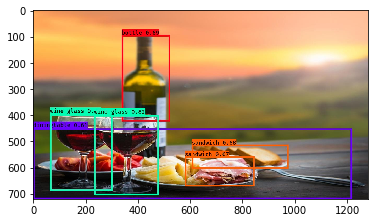

In [15]:
#iniciar sessão no Keras
sess = K.get_session()
out_scores, out_boxes, out_classes = predict(sess, "test3.jpg")

# YOLO9000 (versão 2)

Apesar do algoritmo base da YOLO ser o mesmo em ambas as versões, existem algumas diferenças primordiais para retornar melhores resultados.

A primeira delas foi destacada no notebook da arquitetura da YOLO, onde, apesar das duas arquiteturas seguirem a mesma base em sua formação, alternando-se blocos convolucionais com filtros 1x1 e 3x3 a medida que a profundidade (i.e. quantidade de filtros) dobra, a segunda arquitetura (darknet-19) não possui camadas completamente conectadas, investindo em um modelo completamente convolucional. Essa estratégia retornou melhorias em mAP para a YOLO, como também para os modelos SSD.

Além disso, o modelo v2 utiliza anchor boxes como bounding boxes. Ao utilizar âncoras e um modelo completamente convolucional, a predição torna-se simplificada e mais fácil de aprender. Isso ocorre porque as anchor boxes não retornam as exatas coordenadas na imagem,e sim um offset. 

As anchor boxes são utilizadas por outros modelos de detecção como fast F-CNN e SSD, entretanto, para esses modelos, as dimensões das mesmas são previamente definidas, de forma que ao treinar a rede com outra base de dados, as dimensões podem não ser ideais.

Visando contornar esse problema, a YOLO utiliza o [algoritmo K-Means](https://mubaris.com/2017/10/01/kmeans-clustering-in-python/) para para definir as melhores coordenadas baseado nas dimensões de entrada da imagem. No artigo da YOLO9000, foram realizados diversos experimentos afim de identificar a quantidade de anchor boxes e suas coordenadas com melhores resultados, sendo iguais a 5 (K) para o dataset COCO. As coordenadas das anchor boxes para a base de dados VOC e COCO podem ser encontradas [no repositório da YOLO](https://github.com/pjreddie/darknet/tree/master/cfg) e a implementação do K-Means adaptada para a YOLO pode ser encontrada [aqui](https://github.com/PaulChongPeng/darknet/blob/master/tools/k_means_yolo.py). Seguindo o artigo da YOLO9000, a diferença do K-means é a métrica de distância, calculada a partir da IoU. 

